<div style="display: block; padding: 18px 0; background-color: #ffffcc; color: black; font-size: 20px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:50%; margin:auto">Ladies and Gentlemen start your ML engines</div>

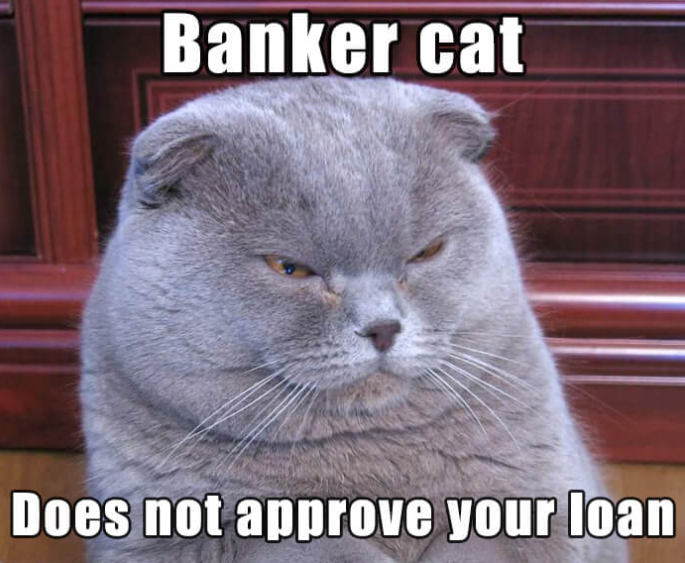

<div style="display: block; padding: 18px 0; background-color: #ffffcc; color: black; font-size: 20px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:50%; margin:auto">IMPORT etc</div>

In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import sys

import matplotlib
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16)/255 for i in (0, 2, 4))

palette = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
palette_rgb = [hex_to_rgb(x) for x in palette]
cmap = mpl_colors.ListedColormap(palette_rgb)
colors = cmap.colors
bg_color= '#fdfcf6'

black, red, green, blue = ['#000000', '#ff0000', '#00ff00', '#0000ff']

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': bg_color,
    'axes.facecolor': bg_color
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import scipy.stats as st

from warnings import simplefilter
simplefilter("ignore")

import random
import os

SEED = 2024
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

from IPython.display import clear_output
from tqdm import tqdm, trange

from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation


from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression
import catboost
from xgboost import XGBClassifier

from sklearn.pipeline import make_pipeline, Pipeline

# Encoders
from sklearn.preprocessing import *
from category_encoders.leave_one_out import LeaveOneOutEncoder 
from category_encoders import TargetEncoder, WOEEncoder

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer

from sklearn.ensemble import *
from sklearn.compose import *

from scipy.stats.mstats import gmean, hmean
from scipy.stats import mode
from numpy import mean, median

import re

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.base import clone
from sklearn.calibration import CalibrationDisplay


from sklearn.feature_selection import *
import eli5
from eli5.sklearn import PermutationImportance
import shap

from termcolor import colored

# &#128297; ENGINE

## ⚖ Averager
We will use it to average different prediction in fold with weights optimized 

In [2]:
from functools import partial
import scipy as sp

class Averager(object):
    
    def __init__(self, method='nelder-mead', round_avg=False, options={}):
        self.weights_ = []
        self.opt_ = ''
        self.method_ = method
        self.round_avg_ = round_avg
        self.options_ = options

    def _weighted_average(self, weights, values):
        qty = len(values)
        sum_values = values[0] * weights[0]
        sum_weights = weights[0]
        for i in range(1, qty):
            sum_values += values[i] * weights[i]
            sum_weights += weights[i]
        if self.round_avg_:
            return int(np.round(sum_values / sum_weights, 0))
        return sum_values / sum_weights

    def _score(self, weights, values, true_labels):
        preds = self._weighted_average(weights, values)
        return LOSS(true_labels, preds)

    def fit(self, values, true_labels):
        qty = len(values)
        initial_weights = [1 for _ in range(qty)]
        score_partial = partial(self._score, values=values, true_labels=true_labels)
        self.opt_ = sp.optimize.minimize(score_partial, initial_weights, method=self.method_, options=self.options_)
        self.weights_ = self.opt_['x']
        
    def predict(self, values):
        assert len(self.weights_) == len(values), 'Averager error, must be fitted before predict'
        return self._weighted_average(self.weights_, values)
    
    def fit_predict(self, values, true_labels):
        self.fit(values, true_labels)
        return self.predict(values)
    
    def weights(self):
        return self.weights_

    def optimization(self):
        return self.opt_
    
    

## &#128188; Classes

In [3]:
class ModelFather():
    
    def __init__(self, name='model', params={}, verbose=1, options={}):
        self.name = name
        self.models_ = []
        self.model_ = None
        self.params_ = params
        self.verbose_ = verbose
        self.options_ = options

    def fit(X, y, X_val, y_val):
        pass

class Regressor(ModelFather):

    def fit_predict(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict(X_val)

    def fit_predict_proba(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict(X_val)

    def predict_proba(self, X):
        return self.predict(X)
    
    def predict(self, X):
        assert self.model_ is not None, 'Model error, must be fitted before predict'
        return self.model_.predict(X)

#         assert len(self.models_) > 0, 'Model error, must be fitted before predict'
#         if len(self.models_) == 1:
#             return self.models_[0].predict(X)
#         return self.averager_.predict([m.predict(X) for m in self.models_])
   
        
class Classifier(ModelFather):

    def fit_predict_proba(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict_proba(X_val)
        
    def predict(self, X):
        return np.rint(self.predict_proba(X)).astype(int)

    def predict_proba(self, X):
        assert self.model_ is not None, 'Model error, must be fitted before predict'
        return self.model_.predict_proba(X)[:, -1]
        
#         assert len(self.models_) > 0, 'Model error, must be fitted before predict'
#         if len(self.models_) == 1:
#             return self.models_[0].predict_proba(X)[:, -1]
#         return self.averager_.predict([m.predict_proba(X)[:, -1] for m in self.models_])

    
class RegressorWrapper(Regressor):
    
    def __init__(self, model, name='model', params={}, verbose=1, options={}):
        super().__init__(name=name, params=params, verbose=verbose, options=options)
        self.model_ = model
        
    def fit(self, X, y, X_val, y_val):
        self.model_.fit(X, y)
    
class ClassifierWrapper(Classifier):
    
    def __init__(self, model, name='model', params={}, verbose=1, options={}):
        super().__init__(name=name, params=params, verbose=verbose, options=options)
        self.model_ = model
        
    def fit(self, X, y, X_val, y_val):
        self.model_.fit(X, y)

In [4]:
class EnsembleClassifier(Classifier):
    
    def __init__(self, classifiers, name='model', params={}, verbose=1, options={}):
        super().__init__(name=name, params=params, verbose=verbose, options=options)
        
        self.classifiers_ = classifiers
        
    def fit_predict_proba(self, X, y, X_val, y_val):
        
        print('\n')

        self.models_ = []

        val_probas = []

        for classifier in self.classifiers_:
            try:
                m = clone(classifier)
            except:
                m = classifier
            val_p = m.fit_predict_proba(X, y, X_val, y_val)
            if self.verbose_ > 0:
                print(colored(f'\n{m.__class__.__name__}: {SCORE(y_val, val_p)}', 'blue'))
            self.models_.append(m)
            val_probas.append(val_p)
        
        if self.verbose_ > 0:
            print('\nPROBAS:')
            for proba in val_probas:
                print(proba)

            probas_mean = np.mean(val_probas, axis=0)
            print('MEAN:\n', probas_mean)

            print(colored(f'{SCORE_NAME} OF MEAN: {SCORE(y_val, probas_mean)}', 'red'))

        self.averager_ = Averager()
        VAL_PROBAS = self.averager_.fit_predict(val_probas, y_val)
        if self.verbose_ > 0:
            print('\nWEIGHTS:\n', self.averager_.weights())
            print('AVGW (weighted average):\n', VAL_PROBAS)

            print(colored(f'{SCORE_NAME} OF AVGW: {SCORE(y_val, VAL_PROBAS)}\n\n', 'red'))
        
        if 'optimize' in self.options_:
            if not self.options_['optimize']:
                return probas_mean
        return VAL_PROBAS
        
            
    def predict_proba(self, X):
        assert len(self.models_) > 0, 'Model error, must be fitted before predict'
        if len(self.models_) == 1:
            return self.models_[0].predict_proba(X)

        probas = [model.predict_proba(X) for model in self.models_]
        
        if 'optimize' in self.options_:
            if not self.options_['optimize']:
                return np.mean(probas, axis=0)
        return self.averager_.predict(probas)       

## &#128295; Setttings

In [5]:
EVALUATE_DATASETS = True
EVALUATE_MODELS   = True
EDA               = True
SUBMIT            = True
OPTUNA            = False
DEBUG             = False
LOAD_SAVED        = True

In [6]:
# CLASSIFICATION

def load_datasets():
    train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
    test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
    sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
    original = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
    
    train = train.drop(['id'], axis=1)
    test = test.drop(['id'], axis=1)
    return train, test, original, sample_sub

PROBLEM = 'classification'

TARGET = 'loan_status'

def SCORE(labels, proba):
    return roc_auc_score(labels, proba)

def LOSS(labels, proba):
    return -roc_auc_score(labels, proba)

SCORE_NAME = 'ROC_AUC'

def CV(model, train_df, test_df, 
    repeats=1, folds=5, seed=42, dataset='base', submission=False, use_tqdm=True, log=True, clear=True,
    param=None, verbose=1):
    
    name = model.name

    train, test = train_df.copy(), test_df.copy()

    features = test.columns.to_list()
    test_features = np.array(test[features])

    cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=seed) #shuffle=True, 

    test_proba_mean = np.zeros(len(test))
    oof_train_proba = np.zeros(len(train))
    oof_true = np.zeros(len(train))
    
    oof_scores = []

    if use_tqdm and verbose > 0:
        data = tqdm(enumerate(cv.split(train[features], train[TARGET])), desc='Fold', total=folds*repeats, file=sys.stdout, colour='GREEN')
    else:
        data = enumerate(cv.split(train[features], train[TARGET]))

    start = datetime.datetime.now()
        
    for i, (train_idx,val_idx) in data:

        train_labels =  train.loc[train_idx, TARGET]
        val_labels =  train.loc[val_idx, TARGET]
        train_features = train.loc[train_idx, features]
        val_features = train.loc[val_idx, features]
        print('\n')
        val_proba =  model.fit_predict_proba(train_features, train_labels, val_features, val_labels)
        test_proba = model.predict_proba(test) #_features
        
        test_proba_mean += test_proba    
            
        val_prediction = np.rint(val_proba).astype(int)
        score = SCORE(val_labels, val_proba)
        oof_scores.append(score)
        if log and verbose > 0:
            print(score)
            
        oof_train_proba[val_idx] = val_proba
        oof_true[val_idx] = val_labels

        if clear:
            clear_output(wait=True)

    execution_time = (datetime.datetime.now() - start).total_seconds() / folds*repeats
            
    mean_oof_score = np.mean(oof_scores)

    prediction = np.rint(oof_train_proba).astype(int)
    score = SCORE(oof_true, oof_train_proba)
    confusion = confusion_matrix(oof_true, prediction)

    test_proba_mean /= folds*repeats

    if verbose > 0:
        print(colored(f'\n{name} on {dataset} dataset performance:\n', 'red'))

        fig, axs = plt.subplots(1, 4, figsize=(36, 5))
        sns.boxplot(oof_scores, ax=axs[0])
        axs[0].set_title(f'OOF {SCORE_NAME}, mean {mean_oof_score}')

        labels = ['class 0', 'Class 1']
        sns.heatmap(confusion, annot=True, annot_kws={"fontsize":24}, fmt=",d", xticklabels=labels, yticklabels=labels, cmap='plasma', cbar=False, ax=axs[1])
        axs[1].set_title(f'Prediction, {SCORE_NAME} {score}')
        axs[1].set_ylabel("Actual Class")
        axs[1].set_xlabel("Predicted Class")    

        RocCurveDisplay.from_predictions(oof_true, oof_train_proba, ax=axs[2])
        axs[2].set_title('ROC')

        CalibrationDisplay.from_predictions(oof_true, np.array(oof_train_proba).clip(0, 1), n_bins=30, strategy='quantile', ax=axs[3])
        axs[3].set_title('Calibration')

        plt.tight_layout()
        plt.show()     
        
        scorer = round(score, 4)
        print(colored(f'\n---------- {SCORE_NAME}: {scorer} ----------:\n', 'red'))

        print('\n---------- Classification Report ----------\n')
        print(classification_report(oof_true, prediction))

    model_accuracy = round(accuracy_score(oof_true, prediction), 4)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(oof_true, prediction, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 4), round(model_recall, 4), round(model_f1, 4)
    model_matthews_corrcoef = round(matthews_corrcoef(oof_true, prediction), 4)

    performance_scores = {
        'Model': name,
        'Dataset': dataset,
        f'Mean OOF {SCORE_NAME}': round(mean_oof_score, 4),
        f'{SCORE_NAME}': scorer,
        'Accuracy Score': model_accuracy,
        'Precision Score': model_precision,
        'Recall Score': model_recall,
        'f1 Score': model_f1,
        'Matthews Corr Coef': model_matthews_corrcoef,
        'time': execution_time,
    }    

    if verbose > 0:
        display(pd.DataFrame([performance_scores]).set_index('Model'))

    if submission:
        sub = sample_sub.copy()
        sub[TARGET] = test_proba_mean
        sub.to_csv(f"{name}_{dataset}_{score:.4f}_{model_f1:.4f}.csv", index=False)
        
        display(sub.head(20))

    return performance_scores, oof_train_proba, test_proba_mean

In [7]:
BASE_MODEL = EnsembleClassifier(
    [
        ClassifierWrapper(LGBMClassifier(n_estimators=50, random_state=42, verbose=-1, objective='binary', metric='auc')) ,
        ClassifierWrapper(XGBClassifier(n_estimators=50, random_state=42, enable_categorical=True, objective='binary:logistic')) ,
    ], 
    name='BASE',
)

## &#128200; Performance Evaluation metrics and plots
> - [Confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
> - [Receiver operating characteristic (ROC)](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)
> - [Calibration Curve](https://scikit-learn.org/stable/modules/calibration.html#calibration)
> - [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)
> - [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
> - [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
> - [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
> - [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 
> - [Matthews Correlation Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)


In [ ]:
def evaluate_dataset(train_df, test_df, name='', clear=True, submisssion=True):
    if EVALUATE_DATASETS:
        train, test = train_df.copy(), test_df.copy()

        object_columns = test.select_dtypes(include=['object']).columns.to_list()
        for df in [train, test]:
            df[object_columns] = df[object_columns].astype('category')

        score, _, _ = CV(BASE_MODEL, train, test, dataset=name, clear=clear)
        datasets_scores[f'{name} dataset'] = score

def display_scores(scores, x='Model'):
    print('\nCOMPARE:')
    df = pd.DataFrame([v for k, v in scores.items()])
    display(df.style.background_gradient(subset=df.columns.to_list().remove('Dataset'), cmap='Greens'))
    mn, mx = df[SCORE_NAME].min(), df[SCORE_NAME].max()
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.barplot(df, x=x, y=SCORE_NAME, ax=ax)
    ax.set(ylim=(mn*0.999, mx*1.001))
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()
    
def fcn(df):
    return df.columns.tolist(), df.select_dtypes(include=['object', 'category']).columns.tolist(), df.select_dtypes(exclude=['object', 'category']).columns.tolist()   

def df_info(df, name='', tab=True, plots=False, info=True, nrows=3):
    print(colored(f'\n---------- {name} ----------:\n', 'red'))
    
    if tab:
        display(df.head(nrows))
        display(df.tail(nrows))
        print(colored(f'{name} has {df.shape[0]} rows, {df.shape[1]} columns\n', 'blue'))

    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    df_missed = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missed'})
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    inf['missed'] = df_missed['missed']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values    
    
    if info:
        display(inf.style.background_gradient(subset='missed', cmap='Reds').background_gradient(subset='unique', cmap='Greens'))
  
    if plots:
        print()
        if df_missed['missed'].sum() > 0:
            fig, ax = plt.subplots(1, 1, figsize=(24, 5))
            sns.barplot(df_missed[df_missed['missed'] > 0], x='column', y='missed', ax=ax)
            ax.set_title(f'{name} missed values') 
            ax.bar_label(ax.containers[0])
            plt.tight_layout()
            plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} unique values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

!pip install dython
from dython.nominal import associations
clear_output()

def df_corr(df, name=''):
    associations_df = associations(df, nominal_columns='all', plot=False)
    corr_matrix = associations_df['corr']
    plt.figure(figsize=(20, 8))
    plt.gcf().set_facecolor('#FFFDD0') 
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title(f'{name} Correlation Matrix including Categorical Features')
    plt.show()
    
from sklearn.decomposition import PCA

def plot_variance(pca, width=10, height=4, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 0.2)
    )

    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="", ylim=(0.0, 1.0)
    )
    
    # Set up figure
    fig.set(figwidth=width, figheight=height,  dpi=100)
    return axs

def make_pca(train, test, display_loadings=True, plots=True):
    features = test.columns.tolist()
    pca = PCA()
    X_pca = pca.fit_transform(train.copy()[features])
    X_test_pca = pca.transform(test.copy()[features])
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    X_test_pca = pd.DataFrame(X_test_pca, columns=component_names)

    if display_loadings:
        loadings = pd.DataFrame(
            pca.components_.T,  # transpose the matrix of loadings
            columns=component_names,  # so the columns are the principal components
            index=features,  # and the rows are the original features
        )
        print('\nLoadings:')
        display(loadings.head(20).style.background_gradient(subset=loadings.columns.to_list(), cmap='Greens'))

    if plots:
        plot_variance(pca)
    return X_pca, X_test_pca

# &#127916; LOAD DATASETS

In [ ]:
train, test, original, sample_sub = load_datasets()

## &#128269;

In [ ]:
cols, _, _  = fcn(test)
for df in [train, test, original]:
    for c in cols:
        for prfx in ['cb_', 'person_', 'loan_']:
            if c.startswith(prfx):
                df.rename(columns={c:c[len(prfx):]}, inplace=True)
cols, _, _  = fcn(test)                
for df in [train, test, original]:
    for c in cols:
        for prfx in ['cb_', 'person_', 'loan_']:
            if c.startswith(prfx):
                df.rename(columns={c:c[len(prfx):]}, inplace=True)                

In [ ]:
df_info(train, 'TRAIN', plots=True)
df_info(test, 'TEST', plots=True)
if original is not None:
    df_info(original, 'ORIGINAL', plots=True)

# &#128202; EDA

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    The target
</div>

In [ ]:
if EDA:
    df, hue  = train, None
    if original is not None:
        t, o = train.copy(), original.copy()
        t['df'] = 'train'
        o['df'] = 'original'
        df, hue = pd.concat([t, o], axis=0), 'df'    
    if PROBLEM == 'regression':
        f = TARGET
        fig, axs = plt.subplots(2, 2, figsize=(24, 10))
        
        ax = axs[0,0]
        sns.kdeplot(train, x=f, label='train', ax=ax, color=red)
        if original is not None:
            sns.kdeplot(original[f], label='original', ax=ax, color=blue)
        ax.set_title(f'{f} distribution')
        ax.legend()
        
        ax = axs[0,1]
        sns.boxplot(df, y=f, x=hue, ax=ax)
        ax.set_title(f'{f} boxplot')
        
        ax = axs[1,0]
        sns.kdeplot(np.log(train[f]), label='train', ax=ax, color=red)
        if original is not None:
            sns.kdeplot(np.log(original[f]), label='original', ax=ax, color=blue)
        ax.set_title(f'log({f}) distribution')
        ax.legend()
        
        ax = axs[1,1]
        sns.boxplot(y=np.log(df[f]), x=df['df'], ax=ax)
        ax.set_title(f'log({f}) boxplot')
        
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.countplot(train, x=TARGET)
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()


The target is not balanced

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    The features
</div>

In [ ]:
def kde_nums(train, test, original):
    _, _, nums = fcn(test)
    columns = nums
    n_cols = 3
    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        plot_axes = [ax[i]]

        sns.kdeplot(train[column], label='Train', ax=ax[i], color=red)

        sns.kdeplot(test[column], label='Test', ax=ax[i], color=blue)

        if original is not None:
            sns.kdeplot(original[column], label='Original', ax=ax[i], color=green)

        # titles
        ax[i].set_title(f'{column} Distribution');
        ax[i].set_xlabel(None)

        # remove axes to show only one at the end
        plot_axes = [ax[i]]
        handles = []
        labels = []
        for plot_ax in plot_axes:
            handles += plot_ax.get_legend_handles_labels()[0]
            labels += plot_ax.get_legend_handles_labels()[1]
            plot_ax.legend().remove()

    for i in range(i+1, len(ax)):
        ax[i].axis('off')

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=3)
    plt.tight_layout()

In [ ]:
if EDA:
    print('Numerical features:')
    kde_nums(train, test, original)

In [ ]:
def count_cats(train, test, n_cols=3, tight=True):
    _, columns, _ = fcn(test)
    if len(columns) == 0:
        return
    n_cols = 4
    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        vc = pd.DataFrame(train[column].value_counts()[:10]).reset_index()
        sns.barplot(vc, y=column, x='count', ax=ax[i])

        # titles
        ax[i].set_title(f'{column} Top 10');
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].bar_label(ax[i].containers[0])

    if tight:
        plt.tight_layout()
    

In [ ]:
if EDA:
    print('Categorical features top most frequent values:')
    count_cats(train, test)

In [ ]:
def count_cats_vs_target(train, test, n_cols=3, tight=True):
    _, columns, _ = fcn(test)
    if len(columns) == 0:
        return

    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        sns.countplot(train, x=column, hue=TARGET, ax=ax[i], palette={0:green, 1:red}) #

        # titles
        ax[i].set_title(f'{column}');
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].bar_label(ax[i].containers[0])

    if tight:
        plt.tight_layout()
        
if EDA and not PROBLEM in ['regression']:    
    print(f'Categorical features distributions vs {TARGET}:')
    count_cats_vs_target(train, test, n_cols=1, tight=True)    

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    Correlation
</div>

In [ ]:
if EDA:
    df_corr(train[:1000], name='TRAIN')     

In [ ]:
df = train.groupby(['grade', 'intent', 'home_ownership'])[TARGET].agg(['mean']).reset_index()
df['gih'] =  df['grade'] + '-' + df['intent'] + '-' + df['home_ownership']
alpha = df[['gih', 'mean']].set_index('gih').to_dict()['mean']
df = df.rename(columns={'mean':'mean_loan_state'})

<div style="display: block; padding: 3px 0; background-color: #ccccff; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:30%; margin:auto">
    grade & intent vs mean loan state
</div>

In [ ]:
if EDA:
    fig = px.scatter(df, x='grade', y='intent', color='mean_loan_state', height=800)
    fig.update_traces(marker=dict(size=50))
    display(fig)

<div style="display: block; padding: 3px 0; background-color: #ccccff; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:30%; margin:auto">
    grade & home ownership vs mean loan state
</div>

In [ ]:
if EDA:
    fig = px.scatter(df, x='grade', y='home_ownership', color='mean_loan_state', height=800)
    fig.update_traces(marker=dict(size=50))
    display(fig)

<div style="display: block; padding: 3px 0; background-color: #ccccff; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:30%; margin:auto">
    intent & home ownership vs mean loan state
</div>

In [ ]:
if EDA:
    fig = px.scatter(df, x='home_ownership', y='intent', color='mean_loan_state', height=800)
    fig.update_traces(marker=dict(size=50))
    display(fig)

<div style="display: block; padding: 3px 0; background-color: #ccccff; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:30%; margin:auto">
    grade & intent & home ownership vs mean loan state
</div>

In [ ]:
if EDA:
    fig = px.scatter_3d(df, x='grade', y='intent', z='home_ownership', color='mean_loan_state', height=800)
    fig.update_traces(marker=dict(size=10))
    display(fig)

# &#128476; PREPROCESS

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    Set the base for dataset evaluation
</div>

In [ ]:
datasets_scores = {}
evaluate_dataset(train, test, 'LOADED') 

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    Add original
</div>

* *and check if the CV score is better*
* *optional, use original or not it depends*

In [ ]:
def add_original(train_, original_):
    f = train_.columns.tolist()
    train = pd.concat([train_, original_[f]], axis=0, ignore_index=True).reset_index(drop=True)
    return train

In [ ]:
if original is not None:
    train_add = add_original(train, original)  
    df_info(train_add)

In [ ]:
if original is not None:    
    evaluate_dataset(train_add, test, 'TRAIN+ORIGINAL')

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Cleaning</h2>
</div>

In [ ]:
px.scatter(train_add, x='age', y='emp_length', color=TARGET)

##### There are outliers, consider to remove

In [ ]:
sns.boxplot(train_add, x='intent', y='int_rate')

* we will remove outliers (clip or drop) in age and emp_length
* fill emp_length with f(age), optional

In [ ]:
def clean(train_, test_):     
    train, test = train_.copy(), test_.copy()
    
    train = train.drop(train[train['age'] > 100].index)
    train = train.drop(train[train['emp_length'] > 100].index)
    train = train.reset_index(drop=True)
    
#     train = train.drop_duplicates(ignore_index=True)
    
#     int_rate_mean = train['int_rate'].mean()
#     k = train['emp_length'].mean() / train['age'].mean()
#     for df in [train, test]:
#         df['age'] = np.clip(df['age'], 15, 70) 
#         df['emp_length'] = np.clip(df['emp_length'], 0, 40) 
#         df['int_rate'] = int_rate_mean
#         df['emp_length'] = df['emp_length'].fillna(df['age'] * k)
    return train, test

train_cleaned, test_cleaned = clean(train_add, test)

In [ ]:
px.scatter(train_cleaned, x='age', y='emp_length', color=TARGET)

In [ ]:
evaluate_dataset(train_cleaned, test_cleaned, 'CLEANED')

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Feature engineering</h2>
</div>

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))
ax = ax.flatten()
column = 'income'
i = 0
sns.kdeplot(train[column], label='Train', ax=ax[i], color=red)
sns.kdeplot(test[column], label='Test', ax=ax[i], color=blue)
# titles
ax[i].set_title(f'{column} Distribution');
ax[i].set_xlabel(None)
i = 1
sns.kdeplot(np.log(train[column]), label='Train', ax=ax[i], color=red)
sns.kdeplot(np.log(test[column]), label='Test', ax=ax[i], color=blue)
# titles
ax[i].set_title(f'log {column} Distribution');
ax[i].set_xlabel(None)
sns.scatterplot(train, x=np.log(train['income']), y='amnt',  hue=TARGET, palette={0:green, 1:red})

plt.tight_layout()

In [ ]:
def feature_engineering(df_):  
    df = df_.copy()
    df['loantoincome'] = (df['amnt'] / df['income']) - df['percent_income']
    df['income'] = np.log(df['income'])
    return df

train_fe, test_fe = feature_engineering(train_cleaned), feature_engineering(test_cleaned)

# train_fe.drop_duplicates(inplace=True, ignore_index=True)

df_info(train_fe, 'TRAIN FE')

In [ ]:
evaluate_dataset(train_fe, test_fe, 'FE')

In [ ]:
df = train_cleaned.groupby(['grade', 'intent', 'home_ownership'])[TARGET].agg(['mean']).reset_index()
df['gih'] =  df['grade'] + '-' + df['intent'] + '-' + df['home_ownership']
alpha = df[['gih', 'mean']].set_index('gih').to_dict()['mean']

In [ ]:
def feature_a(df_):  
    df = df_.copy()
    df['gih'] =  df['grade'] + '-' + df['intent'] + '-' + df['home_ownership']
    df['gih'] = df['gih'].astype('category')
    df['alpha'] = df['gih'].apply(lambda x:alpha[x] if x in alpha else 0.3333)
    return df

train_a, test_a = feature_a(train_cleaned), feature_a(test_cleaned)

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax = ax.flatten()
column = 'alpha'
i = 0
sns.kdeplot(train_a[column], label='Train', ax=ax[i], color=red)
sns.kdeplot(test_a[column], label='Test', ax=ax[i], color=blue)
ax[i].legend()
# titles
ax[i].set_title(f'{column} Distribution');
ax[i].set_xlabel(None)
i = 1
sns.kdeplot(train_a, x=column, label='alpha', hue=TARGET, ax=ax[i], palette={0:green, 1:red})
# titles
ax[i].set_title(f'{column} Distribution');
ax[i].set_xlabel(None)
sns.scatterplot(train_a, x=np.log(train['income']), y=column,  hue=TARGET, palette={0:green, 1:red})

plt.tight_layout()

    # -DL
train_a.drop(['alpha'], axis=1, inplace=True)
test_a.drop(['alpha'], axis=1, inplace=True)

In [ ]:
evaluate_dataset(train_a, test_a, 'FE A')

In [ ]:
im, em, k = train_fe['income'].max(), train_fe['emp_length'].max(), 1
a = k * em / im 
train_b, test_b = train_fe.copy(), test_fe.copy()
train_b['beta'] = a * train_b['income'] + train_b['emp_length']
test_b['beta'] = a * test_b['income'] + test_b['emp_length']

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax = ax.flatten()
column = 'beta'
i = 0
sns.kdeplot(train_b[column], label='Train', ax=ax[i], color=red)
sns.kdeplot(test_b[column], label='Test', ax=ax[i], color=blue)
# titles
ax[i].set_title(f'{column} Distribution');
ax[i].set_xlabel(None)
i = 1
sns.kdeplot(train_b, x=column, label='beta', hue=TARGET, ax=ax[i], palette={0:green, 1:red})
# titles
ax[i].set_title(f'{column} Distribution');
ax[i].set_xlabel(None)
sns.violinplot(train_b, y=column,  x=TARGET)

plt.tight_layout()

In [ ]:
evaluate_dataset(train_b, test_b, 'FE B')

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Imputation</h2>
</div>

In [ ]:
def impute(df_):
    df = df_.copy()
    _, category_columns, nums = fcn(df)
    df[category_columns] = df[category_columns].astype('object').fillna('none').astype('category')
    df[nums] = df[nums].fillna(0)
    return df

train_imputed = impute(train_fe)
test_imputed = impute(test_fe)

df_info(train_imputed, 'TRAIN IMPUTED', tab=False, plots=False)
df_info(test_imputed, 'TEST IMPUTED', tab=False, plots=False)

In [ ]:
evaluate_dataset(train_imputed, test_imputed, 'IMPUTED')

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Encoding</h2>
</div>

In [ ]:
encoder = OrdinalEncoder()
train_encoded, test_encoded = train_imputed.copy(), test_imputed.copy()

category_columns = test_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
tmp_df = pd.concat([train_encoded, test_encoded], axis='rows')
tmp_df[category_columns] = encoder.fit_transform(tmp_df[category_columns])
train_encoded[category_columns] = encoder.transform(train_encoded[category_columns])
train_encoded[category_columns] = train_encoded[category_columns].astype('int32').astype('category')
test_encoded[category_columns] = encoder.transform(test_encoded[category_columns])
test_encoded[category_columns] = test_encoded[category_columns].astype('int32').astype('category')

df_info(train_encoded, 'TRAIN ENCODED', tab=True, plots=False)
df_info(test_encoded, 'TEST ENCODED', tab=True, plots=False)

In [ ]:
evaluate_dataset(train_encoded, test_encoded, 'ENCODED')

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>OneHot Encoding</h2>
</div>

In [ ]:
def onehot(train_, test_):
    encoder = OneHotEncoder(sparse=False)
    train, test = train_.copy(), test_.copy()

    f, c, n = fcn(test)

    # Remove categorical columns (will replace with one-hot encoding)
    num_train = train[n]
    num_test = test[n]
        
    OH_cols_train = pd.DataFrame(encoder.fit_transform(train[c])).astype(int).astype('category')
    OH_cols_test = pd.DataFrame(encoder.transform(test[c])).astype(int).astype('category')

    names = encoder.get_feature_names_out()

    OH_cols_train.columns = names
    OH_cols_test.columns =  names

    # One-hot encoding removed index; put it back
    OH_cols_train.index = train.index
    OH_cols_test.index = test.index

    # Add one-hot encoded columns to numerical features
    OH_train = pd.concat([num_train, OH_cols_train], axis=1)
    OH_test = pd.concat([num_test, OH_cols_test], axis=1)

    # Ensure all columns have string type
    OH_train.columns = OH_train.columns.astype(str)
    OH_test.columns = OH_test.columns.astype(str)
    
    OH_train[TARGET] = train[TARGET]

    return OH_train, OH_test

train_oh, test_oh = onehot(train_imputed, test_imputed)
# train_oh.drop_duplicates(inplace=True, ignore_index=True)
df_info(train_oh, 'TRAIN  OH', tab=True, plots=False)
df_info(test_oh, 'TEST OH', tab=True, plots=False)

In [ ]:
if EDA and not PROBLEM in ['regression']:    
    print(f'OneHot features distributions vs {TARGET}:')
    count_cats_vs_target(train_oh, test_oh, n_cols=6, tight=True)   

In [ ]:
evaluate_dataset(train_oh, test_oh, 'ENCODED')

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Scaling</h2>
</div>

In [ ]:
train_scaled, test_scaled = train_encoded.copy(), test_encoded.copy()
features, cats, nums = fcn(test_scaled)
scaler = StandardScaler()
train_scaled[nums] = scaler.fit_transform(train_scaled[nums])
test_scaled[nums] = scaler.transform(test_scaled[nums])

df_info(train_scaled, 'TRAIN SCALED', tab=True, plots=False)
df_info(test_scaled, 'TEST SCALED', tab=True, plots=False)
kde_nums(train_scaled, test_scaled, None)

In [ ]:
evaluate_dataset(train_scaled, test_scaled, 'SCALED')

### scaling 2

In [ ]:
def scale2(train_, test_):
    train, test = train_.copy(), test_.copy()
    
    features, cats, nums = fcn(test_scaled)

    TRAIN_LN = len(train)
    test[TARGET] = 0
    train = pd.concat([train,test],axis=0,ignore_index=True)   

    # STANDARIZE NUMERICAL FEATURES
    for c in nums:
        print(c,', ',end='')
        m = train[c].mean()
        s = train[c].std()
        train[c] = (train[c]-m)/s
        train[c] = train[c].fillna(0) 
        
    test = train.iloc[TRAIN_LN:]
    train = train.iloc[:TRAIN_LN]
        
    for c in cats:
        train[c] =  train[c].astype('category')
        test[c] =  test[c].astype('category')
    return train, test[features]

train_scaled2, test_scaled2 = scale2(train_encoded, test_encoded)

df_info(train_scaled2, 'TRAIN SCALED2', tab=True, plots=False)
df_info(test_scaled2, 'TEST SCALED2', tab=True, plots=False)
kde_nums(train_scaled2, test_scaled2, None)

In [ ]:
evaluate_dataset(train_scaled2, test_scaled2, 'SCALED 2')

# &#128201; EDA

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>PCA</h2>
</div>

In [ ]:
if EDA:
    train_pca, test_pca = make_pca(train_encoded, test_encoded)
    train_pca[TARGET] = train_encoded[TARGET].astype('string')

In [ ]:
if EDA:
    fig = px.scatter(train_pca, x='PC1', y='PC2', color=TARGET, height=800, color_discrete_map={'0':'green', '1':'red'})
    fig.update_traces(marker=dict(size=6))
    display(fig)

In [ ]:
if EDA:
    fig = px.scatter_3d(train_pca, x='PC1', y='PC2', z='PC3', color=TARGET, height=800, color_discrete_map={'0':'green', '1':'red'})
    fig.update_traces(marker=dict(size=3))
    display(fig)

Classes are not separated

In [ ]:
from sklearn.manifold import TSNE

def make_tsne(train_, test_):
    features = test_.columns.tolist()
    
    X = train_.copy()[features]
    X = X.sample(5000)
    n = 3
    X_tsne = pd.DataFrame(TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(X))
    X_tsne.columns = [f'f{i}' for i in range(n)]
    X_tsne[TARGET] = train[TARGET].astype('string')
    return X_tsne

train_tsne = make_tsne(train_encoded, test_encoded)

In [ ]:
if EDA:
    fig = px.scatter_3d(train_tsne, x='f0', y='f1', z='f2', color=TARGET, height=800, color_discrete_map={'0':'green', '1':'red'})
    fig.update_traces(marker=dict(size=5))
    display(fig)

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Mutual info</h2>
</div>

In [ ]:
from sklearn.feature_selection import *
import eli5
from eli5.sklearn import PermutationImportance
import shap

def mutual_info(train_df, plot=True):
    train = train_df.copy()
    X_train = train.drop([TARGET], axis=1) # [features]
    y_train = train[TARGET]

    if PROBLEM == 'regression':
        mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
    else:
        mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

    mi_scores = pd.Series(mi_scores, name="MI_score", index=X_train.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    df_mi_scores = pd.DataFrame(mi_scores).reset_index().rename(columns={'index':'feature'})
    display(df_mi_scores.style.background_gradient(subset=['MI_score'], cmap='Reds'))
    plt.figure(figsize=(24, 16))
    d = sns.barplot(y=df_mi_scores['feature'], x=df_mi_scores['MI_score'])
    return mi_scores

In [ ]:
if EDA:
    _ = mutual_info(train_encoded)

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Permutation importances</h2>
</div>

In [ ]:
def permutation_importances(train_df, model=BASE_MODEL, plot=True):
    train = train_df.copy()
    X_train = train.drop([TARGET], axis=1) # [features]
    y_train = train[TARGET]

    perm_train, perm_test, perm_y, perm_valid_y = train_test_split(X_train, y_train)
    perm_model = model.fit(perm_train, perm_y)
    perm = PermutationImportance(perm_model, random_state=1).fit(perm_test, perm_valid_y)
    if plot:
        display(eli5.show_weights(perm, feature_names = perm_test.columns.tolist(), top=None))
    return perm

In [ ]:
if EDA:
    if PROBLEM == 'regression':
        model = XGBRegressor(enable_categorical=True)
        _ = permutation_importances(train_encoded, model=model)
    elif PROBLEM == 'classification':
        model = XGBClassifier(enable_categorical=True)
        _ = permutation_importances(train_encoded, model=model)
    else:
        model = XGBClassifier(enable_categorical=True)
        target_encoder = LabelEncoder()
        train_tmp = train_encoded.copy()
        train_tmp[TARGET] = target_encoder.fit_transform(train_tmp[TARGET])
        _ = permutation_importances(train_tmp, model=model)

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Partial dependences</h2>
</div>

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

def partial_dependences(train, test, model_):
    features, _, nums = fcn(test)
    
    X, y = train[features], train[TARGET]
    
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
    model = clone(model_).fit(train_X, train_y)
    
    columns = nums
    n_cols = 3
    n_rows = math.ceil(len(columns)/n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(16, n_rows*5))
    ax = ax.flatten()

    for i, column in enumerate(columns):
        PartialDependenceDisplay.from_estimator(model, val_X, [column], ax=ax[i])
        # titles
        ax[i].set_title(f'{TARGET} vs {column}');
        ax[i].set_xlabel(None)
    plt.tight_layout()
    
if EDA:
    if PROBLEM == 'regression':
        model = XGBRegressor(enable_categorical=True)
        partial_dependences(train_encoded, test_encoded, model)
    elif PROBLEM == 'classification':
        model = XGBClassifier(enable_categorical=True)
        partial_dependences(train_encoded, test_encoded, model)
    else:
        model = XGBClassifier(enable_categorical=True)
        target_encoder = LabelEncoder()
        train_tmp = train_encoded.copy()
        train_tmp[TARGET] = target_encoder.fit_transform(train_tmp[TARGET])
        partial_dependences(train_tmp, test_encoded, model)    

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Select dataset</h2>
</div>

In [ ]:
if EVALUATE_DATASETS:
    display_scores(datasets_scores, x='Dataset')

In [ ]:
train_final, test_final, dataset = train_scaled2.copy(), test_scaled2.copy(), 'SCALED2'

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>Some basic models</h2>
</div>

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

BASE, BASE_TEST = pd.DataFrame(), pd.DataFrame()
BASE[TARGET] = train_final[TARGET]

base_scores = {}

regressors = []
# regressors.append(('MLP', MLPRegressor()))
regressors.append(('Linear', LinearRegression()))
regressors.append(('Ridge', Ridge()))
regressors.append(('LARS', LarsCV()))
regressors.append(('Bayes', BayesianRidge()))
regressors.append(('AdaBoost', AdaBoostRegressor()))
regressors.append(('Bagging', BaggingRegressor()))
regressors.append(('GBoost', GradientBoostingRegressor()))

if EVALUATE_MODELS  or EDA:
    if PROBLEM == 'regression':
        for regressor in regressors:
            MODEL, NAME = regressor[1], regressor[0]    
            print('\n---------- EVALUATING',NAME,'----------\n')
            sc, _ = CV(RegressorWrapper(MODEL, name=NAME), train_final, test_final, dataset=dataset, clear=False)
            base_scores[f'base {NAME}'] = sc
    else:
        for regressor in regressors:
            MODEL, NAME = regressor[1], regressor[0]    
            print('\n---------- EVALUATING',NAME,'----------\n')
            try:
                sc, BASE[NAME], BASE_TEST[NAME] = CV(RegressorWrapper(MODEL, name=NAME), train_final, test_final, dataset=dataset, clear=False)
                base_scores[f'base {NAME}'] = sc
            except Exception as e:
                print(repr(e))
                
    display_scores(base_scores)

# &#128204; CV

<div style="display: block; padding: 3px 0; background-color: #ccffcc; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:40%; margin:auto">
    <h2>LGBM, CATBoost, XGB</h2>
</div>

In [ ]:
train_fin, test_fin = train_fe.copy(), test_fe.copy()

scores = {}
TRAIN, TEST = pd.DataFrame(), pd.DataFrame()
TRAIN[TARGET] = train_final[TARGET]
  
if LOAD_SAVED:
    TRAIN = pd.read_csv('/kaggle/input/loan-approval-data/TRAIN.csv')
    TEST = pd.read_csv('/kaggle/input/loan-approval-data/TEST.csv')
    if 'averager' in TEST.columns.tolist():
        TEST.drop('averager', axis=1, inplace=True)
    SAVED = TEST.columns.tolist()
    y = TRAIN[TARGET]
    for cv in SAVED:
        prediction = np.rint(TRAIN[cv])
        model_accuracy = round(accuracy_score(y, prediction), 4)
        model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y, prediction, average="weighted")
        model_precision, model_recall, model_f1 = round(model_precision, 4), round(model_recall, 4), round(model_f1, 4)
        model_matthews_corrcoef = round(matthews_corrcoef(y, prediction), 4)
        
        scores[f'Saved {cv}'] = {
            'Model': cv,
            'Dataset': 'final',
            f'Mean OOF {SCORE_NAME}': None,
            f'{SCORE_NAME}': SCORE(y, TRAIN[cv]),
            'Accuracy Score': model_accuracy,
            'Precision Score': model_precision,
            'Recall Score': model_recall,
            'f1 Score': model_f1,
            'Matthews Corr Coef': model_matthews_corrcoef,
            'time': 0,
        }   
    display_scores(scores)
    print('\nSAVED RESULTS:\n')

In [ ]:
TRAIN

In [ ]:
import lightgbm as lgb
import xgboost as xgb

f, _, _ = fcn(test_final)
class MultiModelEstimator(Classifier):
        
    def fit_predict_proba(self, X, y, X_val, y_val):
        
        print('\n')

        self.models_, self.regs_ = [], []

        val_probas = []
     
        params = [{}]
        if 'lgb' in self.params_:
            params = self.params_['lgb']
        if params is not False:
            

            for param in params:
                dtrain = lgb.Dataset(X, label=y )
                dvalid = lgb.Dataset(X_val, label=y_val)

                log_evaluation = lgb.log_evaluation(period=200)
                m = lgb.train(
                        param,
                        dtrain,
                        num_boost_round=1500,
                        valid_sets=[dtrain, dvalid],
                        valid_names=['train', 'valid'],
                        categorical_feature=CATS,
                        callbacks = [log_evaluation]
                    )
                val_p = m.predict(X_val)
                if self.verbose_ > 0:
                    print(colored(f'{m.__class__.__name__}: {SCORE(y_val, val_p)}', 'blue'))
                self.models_.append(m)
                self.regs_.append(True)
                val_probas.append(val_p)

        params = [{}]
        if 'xgb' in self.params_:
            params = self.params_['xgb']
        if params is not False:
            for param in params:
                m = XGBClassifier(**param)
#                 print(f'\n{m}')
                m.fit(X, y, eval_set=[(X, y), (X_val, y_val)],
                    early_stopping_rounds = 300,
                    verbose=0,
                )
                val_p = m.predict_proba(X_val)[:,-1]
                if self.verbose_ > 0:
                    print(colored(f'{m.__class__.__name__}: {SCORE(y_val, val_p)}', 'blue'))
                self.models_.append(m)
                self.regs_.append(False)
                val_probas.append(val_p)
            
#             dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)
#             dvalid = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
            
#             eval_set = [(dtrain, 'train'), (dvalid, 'valid')]
            
#             for param in params:
                
#                 m = xgb.train(
#                         params=param,
#                         dtrain=dtrain,
#                         num_boost_round=1500,
#                         maximize=True,
#                         evals=eval_set,
#                         early_stopping_rounds=150,
#                         verbose_eval=200
#                     )
#                 val_p = m.predict(dvalid)
#                 if self.verbose_ > 0:
#                     print(colored(f'{m.__class__.__name__}: {SCORE(y_val, val_p)}', 'blue'))
#                 self.models_.append(m)
#                 self.regs_.append(True)
#                 val_probas.append(val_p)

        params = [{}]
        if 'cat' in self.params_:
            params = self.params_['cat']
        if params is not False:
            
            for param in params:
                _, cat_features, _ = fcn(X)
                
                train_pool = Pool(data=X, label=y, cat_features=cat_features)
                valid_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
                
                m = catboost.CatBoostClassifier(**param)
                m.fit(train_pool, eval_set=valid_pool, verbose=200)
                best_iter = m.best_iteration_
                
                val_p = m.predict_proba(X_val, ntree_end=best_iter)[:,-1]
                if self.verbose_ > 0:
                    print(colored(f'{m.__class__.__name__}: {SCORE(y_val, val_p)}', 'blue'))
                self.models_.append(m)
                self.regs_.append(False)
                val_probas.append(val_p)
        
        if self.verbose_ > 0:
            print('\nPROBAS:')
            for proba in val_probas:
                print(proba)

            probas_mean = np.mean(val_probas, axis=0)
            print('MEAN:\n', probas_mean)

            print(colored(f'{SCORE_NAME} OF MEAN: {SCORE(y_val, probas_mean)}', 'red'))

        self.averager_ = Averager(options={'maxiter':len(val_probas) * 1000})
        VAL_PROBAS = self.averager_.fit_predict(val_probas, y_val)
        if self.verbose_ > 0:
            print('\nWEIGHTS:\n', self.averager_.weights())
            print('AVGW (weighted average):\n', VAL_PROBAS)

            print(colored(f'{SCORE_NAME} OF AVGW: {SCORE(y_val, VAL_PROBAS)}\n\n', 'red'))
        
        if self.optimize_:
            return VAL_PROBAS
        return probas_mean
    
        
    def predict_proba(self, X):
        assert len(self.models_) > 0, 'Model error, must be fitted before predict'
        if len(self.models_) == 1:
            if self.regs_[0]:
                return self.models_[0].predict(X)
            else:
                return self.models_[0].predict_proba(X)[:, -1]

        probas = [self.models_[i].predict(X) if self.regs_[i] else self.models_[i].predict_proba(X)[:, -1] for i in range(len(self.models_))]

        if self.optimize_:
            return self.averager_.predict(probas)
        return np.mean(probas, axis=0)


In [ ]:
if DEBUG:

    FOLDS, REPEATS = 3, 1

    xgb_params = [
        {    
            'objective': 'binary:logistic',
            'enable_categorical'    : True,
            'random_state'          : 42,
        },
    ]

    lgb_params = [{
            'objective': 'binary', 
            'metric':    'auc',
            'random_state'          : 42,
        },
    ]

    cat_params = [
        {
            'task_type'           : "CPU",
            'loss_function'       : 'Logloss',
            'eval_metric'         : "AUC",
            'random_state': 42,
        },
    ]
else:
    FOLDS, REPEATS = 10, 1

    xgb_params = [
        {    
            'objective': 'binary:logistic',
            'learning_rate'         : 0.03, 
            'n_estimators'          : 5_000,
            'max_depth'             : 7, 
            'colsample_bytree'      : 0.75, 
            'colsample_bynode'      : 0.85,
            'colsample_bylevel'     : 0.45,                     
            'reg_alpha'             : 0.001, 
            'reg_lambda'            : 0.25,
            'enable_categorical'    : True,
            'random_state'          : 42,
        },
        {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 7,
        'eta': 0.08,
        'reg_lambda': 38.5,
        'subsample': 0.88,
        'colsample_bytree': 0.65,
        'enable_categorical': True,
        'min_child_weight': 5,
        },
    ]

    lgb_params = [{
            'objective': 'binary', 
            'metric':    'auc',
            'learning_rate'       : 0.0325, 
            'n_estimators'        : 5_000,
            'max_depth'           : 7, 
            'num_leaves'          : 25, 
            'min_data_in_leaf'    : 20,
            'feature_fraction'    : 0.70, 
            'bagging_fraction'    : 0.88, 
            'bagging_freq'        : 6, 
            'lambda_l1'           : 0.001, 
            'lambda_l2'           : 0.1,
        },
        {
            'objective': 'binary', 
            'metric':    'auc',
            'learning_rate'       : 0.035,
            'data_sample_strategy': 'goss', 
            'n_estimators'        : 5_000,
            'max_depth'           : 7, 
            'num_leaves'          : 30, 
            'min_data_in_leaf'    : 30,
            'feature_fraction'    : 0.60, 
            'colsample_bytree'    : 0.65,
            'lambda_l1'           : 0.001, 
            'lambda_l2'           : 1.25,  
        },
        {
            'objective': 'binary',
            'metric': 'auc',
            'max_depth': -1,
            'verbosity': -1,
            'n_estimators': 1500,
            'max_bin': 1024,
            'boosting_type': 'gbdt',
            'colsample_bytree': 0.57,        
            'eta': 0.055,
            'reg_lambda': 10.8,
            'min_child_samples': 70,
            'early_stopping_rounds': 150,
        },
    ]

    cat_params = [
        {
            'task_type'           : "CPU",
            'loss_function'       : 'Logloss',
            'eval_metric'         : "AUC",
            'bagging_temperature' : 0.25,
            'colsample_bylevel'   : 0.40,
            'iterations'          : 5_000,
            'learning_rate'       : 0.045,
            'max_depth'           : 7,
            'l2_leaf_reg'         : 0.80,
            'min_data_in_leaf'    : 30,
            'random_strength'     : 0.25,
            'random_state': 42,
        },
        {
            'iterations': 1500,
            'depth': 6,
            'eta': 0.3, 
            'reg_lambda': 41.0, 
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'random_state': 42,
            'min_data_in_leaf': 51,
            'early_stopping_rounds': 150,
            'verbose':200,
        },
        {
            'iterations': 3000,
            'depth': 7,
            'eta': 0.3, 
            'reg_lambda': 40.0, 
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'random_state': 42,
            'min_data_in_leaf': 51,
            'early_stopping_rounds': 300,
            'verbose':200,
        },
    ]    

In [ ]:
FEATURES, CATS, NUMS = fcn(test_fin)

In [ ]:
train_lx, test_lx = train_fin.copy(), test_fin.copy()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_oe = pd.DataFrame(oe.fit_transform(train_lx[CATS]), columns = CATS).fillna(0).astype(int)

test_oe = pd.DataFrame(oe.transform(test_lx[CATS]), columns = CATS).fillna(0).astype(int)

train_lxe = pd.concat([X_oe, train_lx[NUMS]], axis= 1)
test_lxe = pd.concat([test_oe, test_lx[NUMS]], axis= 1)

train_lxe[TARGET] = train_lx[TARGET]

# df_info(train_lxe, 'TRAIN LXE')
# df_info(test_lxe, 'TEST LXE')

In [ ]:
train_c, test_c = train_fin.copy(), test_fin.copy()

for df in [train_c, test_c]:
    df[FEATURES] = df[FEATURES].fillna(0).astype('string')

# df_info(train_c, 'TRAIN C')
# df_info(test_c, 'TEST C')

<div style="display: block; padding: 3px 0; background-color: #ccccff; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:30%; margin:auto">LGBM</div>

In [ ]:
import lightgbm as lgb
import xgboost as xgb

class LGBEstimator(Classifier):
        
    def fit(self, X, y, X_val, y_val):
        dtrain = lgb.Dataset(X, label=y)
        dvalid = lgb.Dataset(X_val, label=y_val)
        log_evaluation = lgb.log_evaluation(period=200)
        self.model_ = lgb.train(
            self.params_,
            dtrain,
            num_boost_round=1500,
            valid_sets=[dtrain, dvalid],
            valid_names=['train', 'valid'],
            #feval=rmse_metric_lgb,
            categorical_feature=CATS,
            callbacks = [log_evaluation]
        )

    def fit_predict_proba(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict_proba(X_val)
        
    def predict_proba(self, X):
        return self.model_.predict(X, num_iteration=self.model_.best_iteration)

In [ ]:
name = 'LGB0'
if EVALUATE_MODELS and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        LGBEstimator(
            params=lgb_params[0],
            name=name,
        ), 
        train_lxe, 
        test_lxe, 
        dataset='LXE', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=False,
    )
    scores[name] = score

In [ ]:
name = 'LGB1'
if EVALUATE_MODELS and not DEBUG and not name in SAVED and False:
    score, TRAIN[name], TEST[name] = CV(
        LGBEstimator(
            params=lgb_params[1],
            name=name,
        ), 
        train_lxe, 
        test_lxe, 
        dataset='LXE', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=True,
    )
    scores[name] = score

In [ ]:
name = 'LGB2'
if EVALUATE_MODELS and not DEBUG and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        LGBEstimator(
            params=lgb_params[2],
            name=name,
        ), 
        train_lxe, 
        test_lxe, 
        dataset='LXE', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=True,
    )
    scores[name] = score

<div style="display: block; padding: 3px 0; background-color: #ccccff; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:30%; margin:auto">CatBoost</div>

In [ ]:
class CATEstimator(Classifier):
        
    def fit(self, X, y, X_val, y_val):
        cat_features = X.columns.tolist()            
        train_pool = Pool(data=X, label=y, cat_features=cat_features)
        valid_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
        self.model_ = catboost.CatBoostClassifier(**self.params_)
        self.model_.fit(train_pool, eval_set=valid_pool, verbose=200)

    def fit_predict_proba(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict_proba(X_val)
        
    def predict_proba(self, X):
        best_iter = self.model_.best_iteration_
        return self.model_.predict_proba(X, ntree_end=best_iter)[:,-1]

In [ ]:
name = 'CAT'
if EVALUATE_MODELS and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        CATEstimator(
            params=cat_params[0],
            name=name,
        ), 
        train_c, 
        test_c, 
        dataset='CATBoost', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=True,
    )
    scores[name] = score

In [ ]:
name = 'CAT1'
if EVALUATE_MODELS and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        CATEstimator(
            params=cat_params[1],
            name=name,
        ), 
        train_c, 
        test_c, 
        dataset='CATBoost', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=True,
    )
    scores[name] = score

In [ ]:
name = 'CAT2'
if EVALUATE_MODELS and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        CATEstimator(
            params=cat_params[2],
            name=name,
        ), 
        train_c, 
        test_c, 
        dataset='CATBoost', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=True,
    )
    scores[name] = score

<div style="display: block; padding: 3px 0; background-color: #ccccff; color: black; font-size: 12px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:30%; margin:auto">XGB</div>

In [ ]:
import lightgbm as lgb
import xgboost as xgb

class XGBEstimator(Classifier):
        
    def fit(self, X, y, X_val, y_val):
        dtrain = xgb.DMatrix(X.to_numpy(), label=y.to_numpy())
        dvalid = xgb.DMatrix(X_val.to_numpy(), label=y_val.to_numpy())
        eval_set = [(dtrain, 'train'), (dvalid, 'valid')]        
        self.model_ = xgb.train(
            params=self.params_,
            dtrain=dtrain,
            num_boost_round=1500,
            #feval=rmse_metric,
            maximize=True,
            evals=eval_set,
            early_stopping_rounds=150,
            verbose_eval=200
        )

    def fit_predict_proba(self, X, y, X_val, y_val):
        self.fit(X, y, X_val, y_val)
        return self.predict_proba(X_val)
        
    def predict_proba(self, X):
        return self.model_.predict(xgb.DMatrix(X.to_numpy()))

In [ ]:
name = 'XGB0'
if EVALUATE_MODELS and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        XGBEstimator(
            params=xgb_params[0],
            name=name,
        ), 
        train_lxe, 
        test_lxe, 
        dataset='LXE', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=False,
    )
    scores[name] = score

In [ ]:
name = 'XGB1'
if EVALUATE_MODELS and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        XGBEstimator(
            params=xgb_params[1],
            name=name,
        ), 
        train_lxe, 
        test_lxe, 
        dataset='LXE', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=False,
    )
    scores[name] = score

In [ ]:
name = 'E1'
if EVALUATE_MODELS and not name in SAVED:
    score, TRAIN[name], TEST[name] = CV(
        EnsembleClassifier([
                    LGBEstimator(params=lgb_params[0]),
                    LGBEstimator(params=lgb_params[2]),
                    XGBEstimator(params=xgb_params[1]),
                ], 
            name=name), 
        train_lxe, 
        test_lxe, 
        dataset='LXE', 
        log=False,
        folds=FOLDS,
        repeats=REPEATS,
        submission=False,
    )
    scores[name] = score

In [ ]:
TRAIN.to_csv("TRAIN.csv", index=False)
TEST.to_csv("TEST.csv", index=False)

In [ ]:
display_scores(scores)

In [ ]:
name = 'STACK'
STACK = ['LGB0', 'LGB2', 'CAT', 'CAT1', 'XGB1', 'E1', 'CAT2']
if EVALUATE_MODELS:
    score, TRAIN[name], TEST[name] = CV(
        ClassifierWrapper(LogisticRegression(penalty='l2',  C=10, max_iter=15000, tol=1e-6), name=name), 
        TRAIN[STACK + [TARGET]], 
        TEST[STACK], 
        dataset='STACK', 
        log=False,
        submission=True,
        folds=10,
        repeats=1,
    )
    scores[name] = score
    display_scores(scores)

In [ ]:
STACK = ['LGB0', 'LGB2', 'CAT', 'CAT1', 'CAT2'] 
val_probas = [TRAIN[col].values for col in STACK]
print('val_probas:')
for proba in val_probas:
    print(proba)
    
maxiter = len(STACK) * 15000
    
y_val = TRAIN[TARGET].values
averager = Averager(options={'maxiter':maxiter})
VAL_PROBAS = averager.fit_predict(val_probas, y_val)
print('\nWEIGHTS:\n', averager.weights())
print('AVGW (weighted average):\n', VAL_PROBAS)

score_averager = round(SCORE(y_val, VAL_PROBAS), 5)
print(colored(f'{SCORE_NAME} OF AVGW: {score_averager}\n\n', 'red'))

test_probas = [TEST[col].values for col in STACK]
print('test_probas:')
for proba in test_probas:
    print(proba)
    
TEST_PROBAS = averager.predict(test_probas)
print('weighted average:\n', TEST_PROBAS, '\n')

TEST['averager'] = TEST_PROBAS
TEST

# &#128190; SUBMISSION

In [ ]:
sub = sample_sub.copy()
sub[TARGET] = TEST['averager']
sub.to_csv(f"averager_{score_averager}.csv", index=False)
display(sub.head(20))

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: lightgreen; font-size:100%; text-align:left">  
    <h1 align="center" style="color:red;">Thanks!</h1>
    <h3 align="center">If you liked it, I would be very pleased for an upvote</h3>
</div>

<div style="display: block; padding: 18px 0; background-color: #ffffcc; color: black; font-size: 20px; font-weight: bold; border-radius: 12px; text-align: center; width: 100%; box-shadow: inset 4px 4px 8px rgba(255, 255, 255, 0.5), inset -4px -4px 8px rgba(0, 0, 0, 0.3); width:80%; margin:auto">
    <h1>APPENDIX A. HYPERPARAMETERS TUNING</h1>
</div>

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    params = {
        'lgb': {
            'n_estimators': trial.suggest_int('lgb_n_estimators', 300, 5000),
            'learning_rate': trial.suggest_float('lgb_learning_rate', 0.001, 1, log=True),
#             'max_depth': trial.suggest_int('lgb_max_depth', 7, 10),
#             'reg_lambda': trial.suggest_float('lgb_lambda_l2', 0.01, 10.0, log=True),
#             'num_leaves': trial.suggest_int('lgb_num_leaves', 2, 512),
        },
        'cat': {
            'iterations': trial.suggest_int('cat_iterations', 500, 5000),
            'learning_rate': trial.suggest_float('cat_learning_rate', 0.001, 1, log=True),
#             'depth': trial.suggest_int('cat_depth', 3, 12),
#             'reg_lambda': trial.suggest_float('cat_lambda_l2', 0.01, 10.0, log=True),
        },
        'xgb': {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 300, 10000),
            'learning_rate': trial.suggest_float('xgb_learning_rate', 0.001, 1, log=True),
#             'max_depth': trial.suggest_int('xgb_max_depth', 3, 12),
#             'lambda': trial.suggest_float('xgb_lambda', 0.01, 10.0, log=True),
#             'num_leaves': trial.suggest_int('xgb_num_leaves', 2, 512),
        },
        'nn': False,
    }

    score, _ = CV(NN_LGB_CAT_XGB_Regressor(params=params, name='NN_LGB_CAT_XGB'), train_final, test_final, dataset=dataset, folds=2, verbose=-1)
    return score[SCORE_NAME]

In [ ]:
if OPTUNA:
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10, timeout=600)

In [ ]:
if OPTUNA:
    display(optuna.visualization.plot_slice(study))
    display(optuna.visualization.plot_optimization_history(study))
    
    print("Number of1 finished trials:", len(study.trials))
    print("\nBest trial:")
    trial = study.best_trial

    print("\nValue: ", trial.value)

    optuna_params = trial.params
    print("\nParams:", optuna_params)
    tuned_param = {'lgb':{}, 'cat':{}, 'xgb':{}}
    
    for k, v in optuna_params.items():
        item = k.split('_')
        k1 = item[0]
        k2 = k[len(k1)+1:]
        tuned_param[k1][k2] = v
        
    print('\nTuned:', tuned_param)

In [ ]:
if OPTUNA:
    score, _ = CV(LGB_CAT_XGB_FIT_PREDICT_R, train, test, folds=5, dataset='final', log=False, param=tuned_param)
    scores['LGB CAT XGB tuned'] = score
    display_scores(scores)